In [7]:
import os
import glob
import spacy
import random
import warnings
from matplotlib import pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sns

# set the random seed for reproducibility
random.seed(123)
# turn off depreciation warnings and future warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# load spacy model
nlp = spacy.load('en_core_web_lg')

# function to load data
def load_data(base_dir):
    data = []
    labels = []
    files = []
    for label in ['positive', 'negative']:
        for filepath in glob.glob(os.path.join(base_dir, label, '*.txt')):
            with open(filepath, 'r', encoding='utf-8') as file:
                data.append(file.read())
                labels.append(1 if label == 'positive' else 0)
                files.append(filepath)
                
    return data, labels, files

# delete the contents after "What I've decided and why"
def clean_data(data):
    cleaned_data = []
    for text in data:
        cleaned_data.append(text.split("What I've decided and why")[0])
    return cleaned_data


## Vfidf vectorizer and Logistic Regression

In [8]:
# preprocess the texts
def preprocess_texts(texts):
    docs = [nlp(text) for text in texts]
    return docs

# function to remove stopwords and punctuation
def remove_stopwords_punctuation(docs):
    cleaned_docs = []
    for doc in docs:
        doc = [token for token in doc if not token.is_stop and not token.is_punct]
        doc = [token for token in doc if token.text not in ['\n', 'Mr', 'Mrs', 'Miss', 'Ms']]
        doc = [token for token in doc if len(token.text) > 1]
        doc = [token for token in doc if not token.text.isnumeric()]
        cleaned_docs.append(doc)
    return cleaned_docs

#  lowercase and lemmatise the tokens
def lowercase_and_lemmatise(docs):
    lemmatised_docs = []
    for doc in docs:
        lemmatised_tokens = [token.lemma_.lower() for token in doc]
        lemmatised_docs.append(lemmatised_tokens)
    return lemmatised_docs

# join the tokens back together
def join_tokens(docs):
    return [' '.join(doc) for doc in docs]

# load training data
train_data, train_labels, train_files = load_data('data/train')
# print the number of training samples
print(f'Number of training samples: {len(train_data)}')
# load test data
test_data, test_labels, test_files = load_data('data/test')
# print the number of test samples
print(f'Number of test samples: {len(test_data)}')

train_data = clean_data(train_data)
test_data = clean_data(test_data)

# preprocess the training data
train_data = preprocess_texts(train_data)
# preprocess the test data
test_data = preprocess_texts(test_data)

# remove stopwords and punctuation from the training data
train_data = remove_stopwords_punctuation(train_data)
# remove stopwords and punctuation from the test data
test_data = remove_stopwords_punctuation(test_data)

# lowercase and lemmatise the training data
train_data = lowercase_and_lemmatise(train_data)
# lowercase and lemmatise the test data
test_data = lowercase_and_lemmatise(test_data)

# join the tokens back together for the training data
train_data = join_tokens(train_data)
# join the tokens back together for the test data
test_data = join_tokens(test_data)

Number of training samples: 925
Number of test samples: 232


In [23]:
# 查找包含 uphold complaint 的文本
uphold_complaint = [text for text in train_data if 'uphold complaint' in text]
print(f'Number of texts containing "uphold complaint": {len(uphold_complaint)}')
# 打印具体的文件名
num = 0
for text in uphold_complaint:
    print(train_files[train_data.index(text)])
    num += 1
    if num == 3:
        break

Number of texts containing "uphold complaint": 373
data/train/positive/DRN-4719905.txt
data/train/positive/DRN-4771184.txt
data/train/positive/DRN-4731470.txt


In [6]:
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Evaluate model and return metrics
def evaluate_model(model, test_data, test_labels, data_type='test'):
    predictions = model.predict(test_data)
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions)
    recall = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)
    conf_matrix = confusion_matrix(test_labels, predictions)
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

    print(f'{data_type} data metrics:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Confusion Matrix: \n{conf_matrix}')

    return results


## TfidfVectorizer and Logistic Regression

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# create a pipeline with TfidfVectorizer and LogisticRegression
logreg_text_clf_pipeline = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression(max_iter=1000, random_state=123)
)

# define parameter grid for GridSearchCV
param_grid_logreg = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'tfidfvectorizer__max_df': [0.9, 0.95],
    'tfidfvectorizer__min_df': [2, 5],
    'logisticregression__C': [0.1, 1, 10]
}

# perform GridSearchCV
grid_search_logreg = GridSearchCV(logreg_text_clf_pipeline, param_grid_logreg, cv=5, n_jobs=-1, verbose=1)
grid_search_logreg.fit(train_data, train_labels)

# best model
best_logreg_model = grid_search_logreg.best_estimator_

# print the best parameters
print(grid_search_logreg.best_params_)

# evaluate the best model on the training data
train_metrics_logreg = evaluate_model(best_logreg_model, train_data, train_labels, data_type='train')

# evaluate the best model on the test data
test_metrics_logreg = evaluate_model(best_logreg_model, test_data, test_labels, data_type='test')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'logisticregression__C': 10, 'tfidfvectorizer__max_df': 0.95, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 4)}
train data metrics:
Accuracy: 0.9946
Precision: 0.9913
Recall: 0.9978
F1 Score: 0.9946
Confusion Matrix: 
[[463   4]
 [  1 457]]
test data metrics:
Accuracy: 0.7543
Precision: 0.7458
Recall: 0.7652
F1 Score: 0.7554
Confusion Matrix: 
[[87 30]
 [27 88]]


## Vfidf vectorizer and SVC

In [5]:
from sklearn.svm import SVC

# Create a pipeline with TfidfVectorizer and SVC
svm_text_clf_pipeline = make_pipeline(
    TfidfVectorizer(),
    SVC(probability=True, random_state=123)
)

# Define parameter grid for GridSearchCV
param_grid_svc = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'tfidfvectorizer__max_df': [0.9, 0.95],
    'tfidfvectorizer__min_df': [2, 5],
    'svc__C': [0.1, 1, 10]
}

# Perform GridSearchCV
grid_search_svc = GridSearchCV(svm_text_clf_pipeline, param_grid_svc, cv=5, n_jobs=-1, verbose=1)
grid_search_svc.fit(train_data, train_labels)

# Best model
best_svc_model = grid_search_svc.best_estimator_

# Print the best parameters
print(grid_search_svc.best_params_)

# Get model metrics
train_metrics_svc = evaluate_model(best_svc_model, train_data, train_labels, data_type='Train')
print('-'*50)
test_metrics_svc = evaluate_model(best_svc_model, test_data, test_labels, data_type='Test')


Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'svc__C': 10, 'tfidfvectorizer__max_df': 0.9, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 1)}
Train data metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix: 
[[467   0]
 [  0 458]]
--------------------------------------------------
Test data metrics:
Accuracy: 0.7414
Precision: 0.7273
Recall: 0.7652
F1 Score: 0.7458
Confusion Matrix: 
[[84 33]
 [27 88]]


## Vfidf vectorizer and RandomForest

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline with TfidfVectorizer and RandomForestClassifier
rf_text_clf_pipeline = make_pipeline(
    TfidfVectorizer(decode_error='ignore'),
    RandomForestClassifier(n_jobs=-1, random_state=123)
)

# Define parameter grid for GridSearchCV
param_grid_rf = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'tfidfvectorizer__max_df': [0.9, 0.95],
    'tfidfvectorizer__min_df': [2, 5],
}

# Perform GridSearchCV
grid_search_rf = GridSearchCV(rf_text_clf_pipeline, param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(train_data, train_labels)

# Best model
best_rf_model = grid_search_rf.best_estimator_

# Print the best parameters
print(grid_search_rf.best_params_)
# Get model metrics
train_metrics_rf = evaluate_model(best_rf_model, train_data, train_labels, data_type='Train')
print('-'*50)
test_metrics_rf = evaluate_model(best_rf_model, test_data, test_labels, data_type='Test')


Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'tfidfvectorizer__max_df': 0.9, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 3)}
Train data metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix: 
[[467   0]
 [  0 458]]
--------------------------------------------------
Test data metrics:
Accuracy: 0.8319
Precision: 0.8333
Recall: 0.8261
F1 Score: 0.8297
Confusion Matrix: 
[[98 19]
 [20 95]]


## Tf-idf vectorizer and Naive Bayes model

In [7]:

from sklearn.naive_bayes import MultinomialNB

# Create a pipeline with TfidfVectorizer and MultinomialNB
nb_text_clf_pipeline = make_pipeline(
    TfidfVectorizer(decode_error='ignore'),
    MultinomialNB()
)

# Define parameter grid for GridSearchCV
param_grid_nb = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'tfidfvectorizer__max_df': [0.9, 0.95],
    'tfidfvectorizer__min_df': [2, 5],
    'multinomialnb__alpha': [0.1, 1, 10]
}

# Perform GridSearchCV
grid_search_nb = GridSearchCV(nb_text_clf_pipeline, param_grid_nb, cv=5, n_jobs=-1, verbose=1)
grid_search_nb.fit(train_data, train_labels)

# Best model
best_nb_model = grid_search_nb.best_estimator_

# Print the best parameters
print(grid_search_nb.best_params_)
# Get model metrics
train_metrics_nb = evaluate_model(best_nb_model, train_data, train_labels, data_type='Train')
print('-'*50)
test_metrics_nb = evaluate_model(best_nb_model, test_data, test_labels, data_type='Test')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'multinomialnb__alpha': 0.1, 'tfidfvectorizer__max_df': 0.9, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 3)}
Train data metrics:
Accuracy: 0.8886
Precision: 0.8834
Recall: 0.8930
F1 Score: 0.8882
Confusion Matrix: 
[[413  54]
 [ 49 409]]
--------------------------------------------------
Test data metrics:
Accuracy: 0.7371
Precision: 0.7250
Recall: 0.7565
F1 Score: 0.7404
Confusion Matrix: 
[[84 33]
 [28 87]]


## ROC curve

In [1]:
# create a function to plot the roc curve

from sklearn.metrics import roc_curve, auc

# function returns fpr, tpr and auc
def get_roc_curve(model, test_data, test_labels):
    probabilities = model.predict_proba(test_data)[:, 1]
    fpr, tpr, _ = roc_curve(test_labels, probabilities)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

# plot the roc curve
def plot_roc_curve(models, model_names, test_data, test_labels, data_type='test'):
    plt.figure(figsize=(8, 8))
    for model, model_name in zip(models, model_names):
        fpr, tpr, auc_score = get_roc_curve(model, test_data, test_labels)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    # ratio set to 'equal' to ensure the aspect ratio is equal
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(f'ROC Curve ({data_type} data)', fontsize=16)
    plt.legend(fontsize=14)
    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig(f'plots/roc-curve-{data_type}.png', dpi=300)
    plt.show()

# plot the roc curve
models = [best_logreg_model, best_svc_model, best_rf_model, best_nb_model]
model_names = ['Logistic Regression', 'SVC', 'Random Forest', 'Naive Bayes']
plot_roc_curve(models, model_names, train_data, train_labels, data_type='train')
plot_roc_curve(models, model_names, test_data, test_labels, data_type='test')


NameError: name 'best_logreg_model' is not defined

<Figure size 1200x800 with 0 Axes>

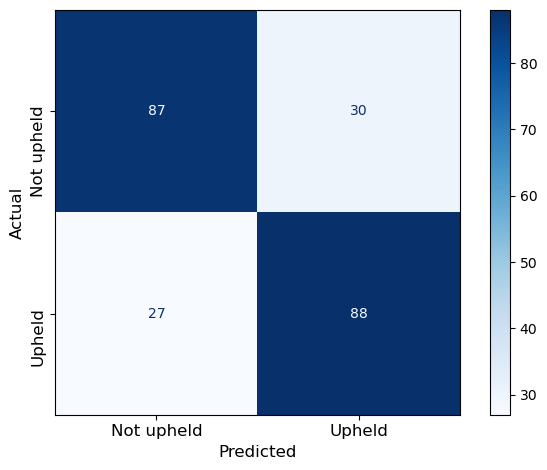

<Figure size 1200x800 with 0 Axes>

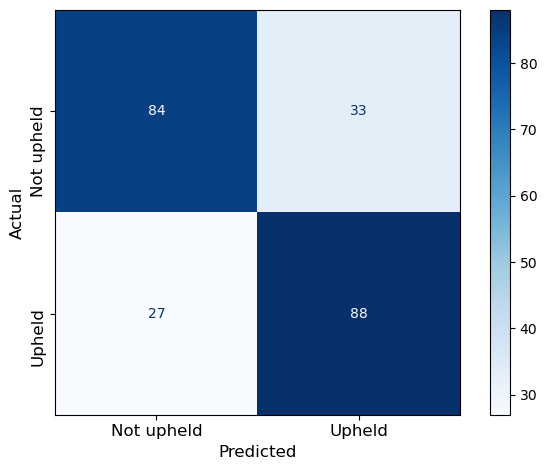

<Figure size 1200x800 with 0 Axes>

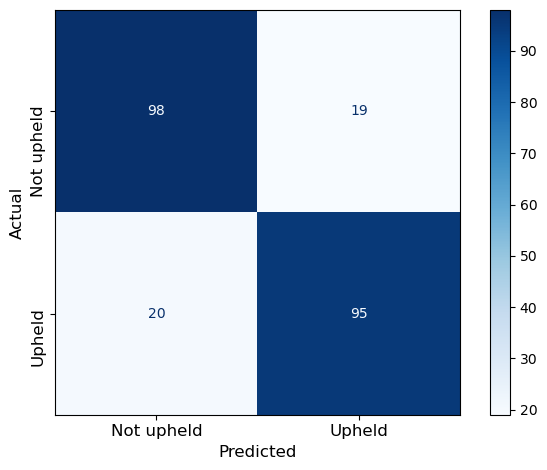

<Figure size 1200x800 with 0 Axes>

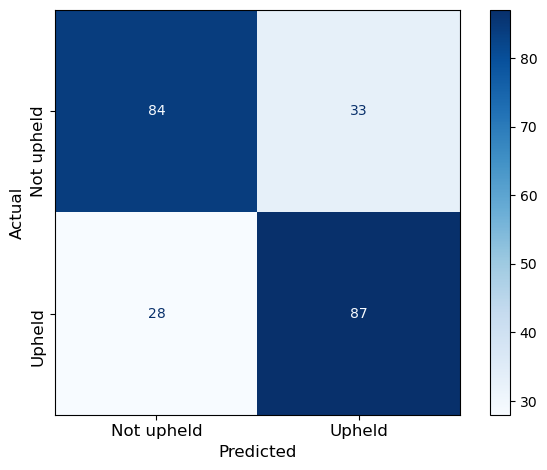

<Figure size 1200x800 with 0 Axes>

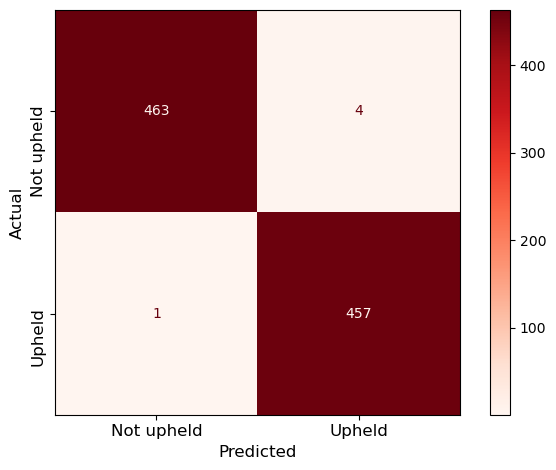

<Figure size 1200x800 with 0 Axes>

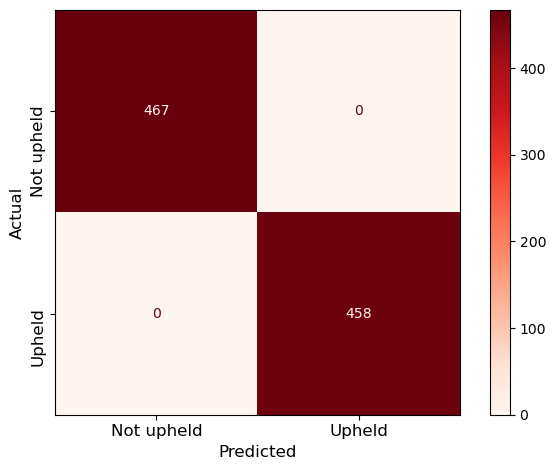

<Figure size 1200x800 with 0 Axes>

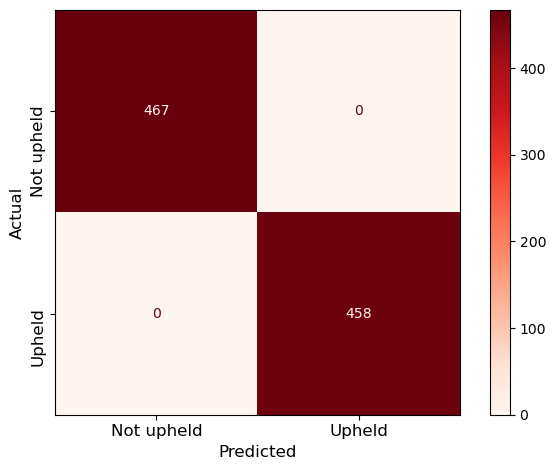

<Figure size 1200x800 with 0 Axes>

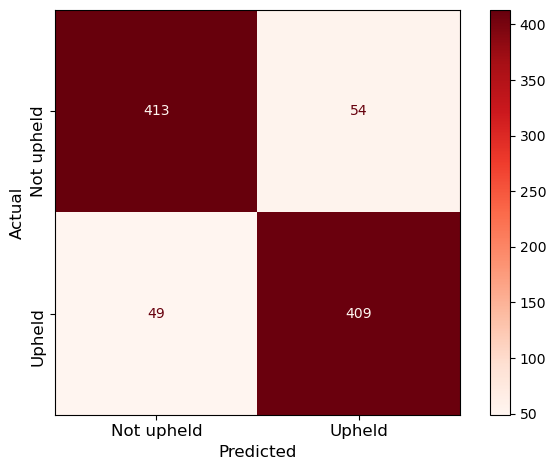

In [47]:
import matplotlib.pyplot as plt
from pycm import ConfusionMatrix
import os

def generate_confusion_matrices(models, test_data, test_labels):
    confusion_matrices = []
    for model in models:
        predictions = model.predict(test_data)
        cm = ConfusionMatrix(actual_vector=test_labels,
                              predict_vector=predictions)
        confusion_matrices.append(cm)
    return confusion_matrices

def plot_confusion_matrix(cm, model_name, data_type='test'):
    plt.figure(figsize=(12, 8))
    if data_type == 'test':
        cm.plot(cmap=plt.cm.Blues, number_label=True, plot_lib='matplotlib')
    else:
        cm.plot(cmap=plt.cm.Reds, number_label=True, plot_lib='matplotlib')
    
    # ticks: 1 -> Upheld, 0 -> Not upheld
    plt.xticks([0, 1], ['Not upheld', 'Upheld'], fontsize=12)
    plt.yticks([0, 1], ['Not upheld', 'Upheld'], fontsize=12, rotation=90)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    #plt.title(f'{model_name} ({data_type} data)')
    plt.title("")
    plt.tight_layout()
    
    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig(f'plots/confusion-matrix-{model_name}-{data_type}.png', dpi=300)
    plt.show()

# Example usage
confusion_matrices = generate_confusion_matrices(models, test_data, test_labels)
for i, cm in enumerate(confusion_matrices):
    plot_confusion_matrix(cm, model_names[i], data_type='test')

confusion_matrices = generate_confusion_matrices(models, train_data, train_labels)
for i, cm in enumerate(confusion_matrices):
    plot_confusion_matrix(cm, model_names[i], data_type='train')

## Feature Importance

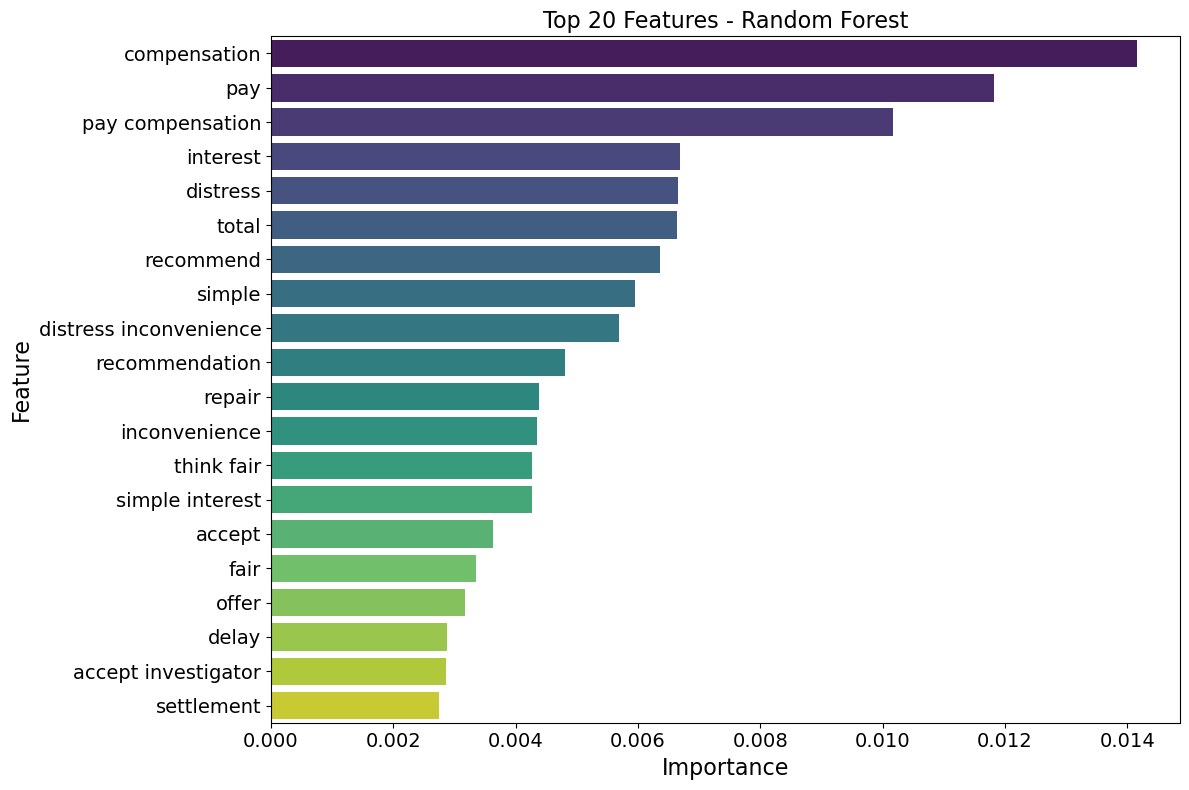

In [19]:
## Feature Importance
# get the feature names from the TfidfVectorizer
feature_names = best_rf_model.named_steps['tfidfvectorizer'].get_feature_names_out()

# Get the feature importances from the RandomForestClassifier
feature_importances = best_rf_model.named_steps['randomforestclassifier'].feature_importances_

# Create a DataFrame with the feature names and feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# get the top 20 features
top_20_features = feature_importance_df.sort_values('importance', ascending=False).head(20)

# plot the top 20 features
def plot_feature_importance(feature_df, title):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_df, palette='viridis')
    plt.xlabel('Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    title = title.lower().replace(' ', '-')
    plt.savefig(f'plots/{title}.png', dpi=300)
    plt.show()

# plot the top 20 features
plot_feature_importance(top_20_features, 'Top 20 Features - Random Forest')

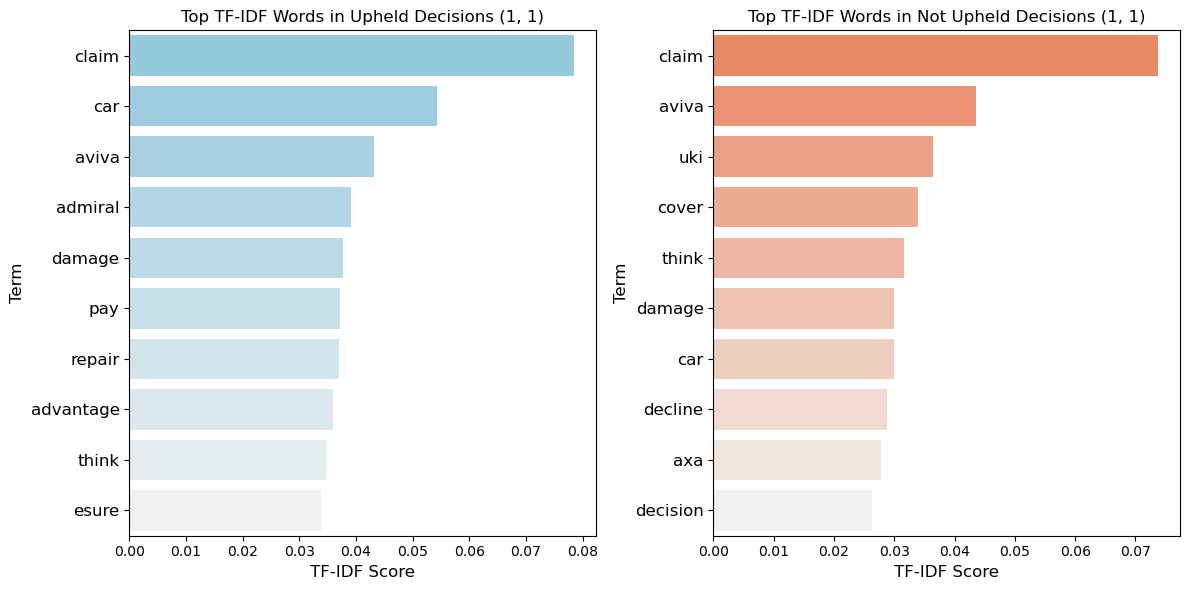

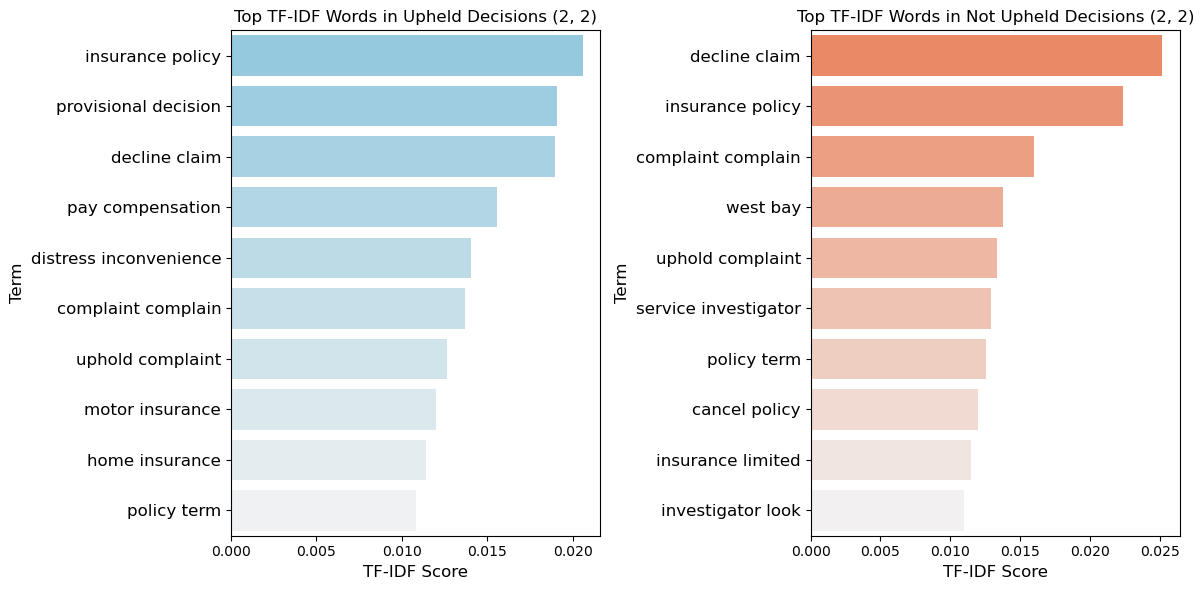

In [20]:
# Use TfidfVectorizer to calculate TF-IDF scores
vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_df=0.9, min_df=2)
train_tfidf = vectorizer.fit_transform(train_data)
feature_names = vectorizer.get_feature_names_out()

# get TF-IDF scores for positive and negative labels
positive_tfidf = train_tfidf.toarray()[[i for i, label in enumerate(train_labels) if label == 1]]
negative_tfidf = train_tfidf.toarray()[[i for i, label in enumerate(train_labels) if label == 0]]

# calculate average TF-IDF scores for each word in both categories
positive_scores = positive_tfidf.mean(axis=0)
negative_scores = negative_tfidf.mean(axis=0)

# create dataframes for the top words and their scores
positive_df = pd.DataFrame({'word': feature_names, 'score': positive_scores}).nlargest(10, 'score')
negative_df = pd.DataFrame({'word': feature_names, 'score': negative_scores}).nlargest(10, 'score')


# function to calculate TF-IDF and plot results
def plot_top_tfidf_words(data, labels, ngram_range=(1, 1), top_n=10):
    # ese TfidfVectorizer to calculate TF-IDF scores
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_df=0.9, min_df=2)
    tfidf_matrix = vectorizer.fit_transform(data)
    feature_names = vectorizer.get_feature_names_out()

    # get TF-IDF scores for positive and negative labels
    positive_tfidf = tfidf_matrix.toarray()[[i for i, label in enumerate(labels) if label == 1]]
    negative_tfidf = tfidf_matrix.toarray()[[i for i, label in enumerate(labels) if label == 0]]

    # calculate average TF-IDF scores for each word in both categories
    positive_scores = positive_tfidf.mean(axis=0)
    negative_scores = negative_tfidf.mean(axis=0)

    # create dataframes for the top words and their scores
    positive_df = pd.DataFrame({'word': feature_names, 'score': positive_scores}).nlargest(top_n, 'score')
    negative_df = pd.DataFrame({'word': feature_names, 'score': negative_scores}).nlargest(top_n, 'score')

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x='score', y='word', data=positive_df, palette="light:skyblue_r")
    plt.title('Top TF-IDF Words in Upheld Decisions {}'.format(ngram_range))
    plt.xlabel('TF-IDF Score', fontsize=12)
    plt.ylabel('Term', fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='score', y='word', data=negative_df, palette='light:coral_r')
    plt.title('Top TF-IDF Words in Not Upheld Decisions {}'.format(ngram_range))
    plt.xlabel('TF-IDF Score', fontsize=12)
    plt.ylabel('Term', fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()

    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig(f'plots/top-tfidf-words-{ngram_range}.png', dpi=300)
    plt.show()


# Plot the top TF-IDF words for unigrams
plot_top_tfidf_words(train_data, train_labels, ngram_range=(1, 1), top_n=10)

# Plot the top TF-IDF words for bigrams
plot_top_tfidf_words(train_data, train_labels, ngram_range=(2, 2), top_n=10)